Data Analysis Pipeline:


*  Clone the repo to carry the dependencies over and to invoke imagene.py.
*  Import all necessary modules.


*   Read VCF file, extract the data, and create an ImaGene object.

*   Simulate data for strong and early selection selrange = seq 0 300 300 / timerange = 0.01.
*   Build and compile baseline model.


*   Train model on training data and gather metrics.

*   Test trained network on unseen data.
*   Test trained network on real genomic data.













In [1]:
# Cloning the GitHub repository
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Change directories into the specified directory
%cd EvoNet-CNN-Insight/model_training/Early_Strong



Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 1616, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1616 (delta 136), reused 215 (delta 99), pack-reused 1351
Receiving objects: 100% (1616/1616), 3.06 GiB | 24.36 MiB/s, done.
Resolving deltas: 100% (304/304), done.
Updating files: 100% (67/67), done.
/content/EvoNet-CNN-Insight/model_training/Early_Strong


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers



# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc
import pydot  # Optional, but required by keras to plot the model

In [3]:
%run -i ../ImaGene.py

 Read data from VCF file and store it into _ImaGene_ objects



In [4]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='../LCT.CEU.vcf')
gene_LCT = file_LCT.read_VCF()
gene_LCT.summary();

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 2200, max 2200, mean 2200.000000, std 0.000000


In [5]:
gene_LCT.filter_freq(0.01);

sort rows by frequency (most frequent haplotypes on top) and visualize the result, use this command:

In [6]:
gene_LCT.sort('rows_freq');

After data processing (e.g., filtering and sorting), convert the image to the appropriate format for prediction. Flip black and white pixels to assign black to derived (or minor) alleles, as is standard in genomic data representation. The images should be white.








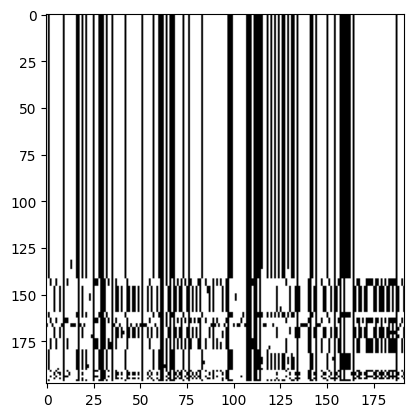

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


In [7]:
gene_LCT.convert(flip=True);
gene_LCT.plot();
gene_LCT.summary();

In [8]:
path = './'

In [9]:
gene_LCT.save(file=path + 'gene_LCT');

In [10]:
gene_LCT = load_imagene(file=path + 'gene_LCT');

ImaGene uses msms to run simulations for training. Use ../generate_dataset.sh with ../params.txt (modify as needed).

params_earl_weak.txt simulates 200,000 loci (80kbp) under neutral evolution or positive selection (1.5% selection coefficient). Selection starts 800 generations ago with an allele frequency of 0.01. Mutation rate: 1.5e-8, recombination rate: 1e-8. Model follows Marth et al. 2004, sampling 198 chromosomal copies.

Specify directories for msms and simulation storage, then run the command. The script splits simulations into batches for training.

In [11]:
# if you wish to generate new training data, do not run otherwise
import subprocess
subprocess.call("bash ../generate_dataset.sh params_early_strong.txt".split());

In [12]:

path_sim = './'

In [13]:
file_sim = ImaFile(simulations_folder=path_sim + 'ES/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Populate an ImaGene object by specifying the variable to estimate (selection_coeff_hetero) and the number of data points per class. Use 2000 data points per class as an example.

In [14]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000);

In [15]:
gene_sim.filter_freq(0.01);
gene_sim.sort('rows_freq');


In [16]:
gene_sim.resize((198, 192));

In [17]:
gene_sim.convert(flip=True);


shuffle images before using them for training network.


In [18]:
gene_sim.subset(get_index_random(gene_sim));

In [19]:
gene_sim.targets = to_binary(gene_sim.targets);

In [20]:
gene_sim.save(file=path + 'gene_sim.binary')

0

In [21]:
gene_sim = load_imagene(file=path + 'gene_sim.binary')

Build and compile the model.

In [22]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

In [23]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 190, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 95, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 93, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 44, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 22, 64)        0

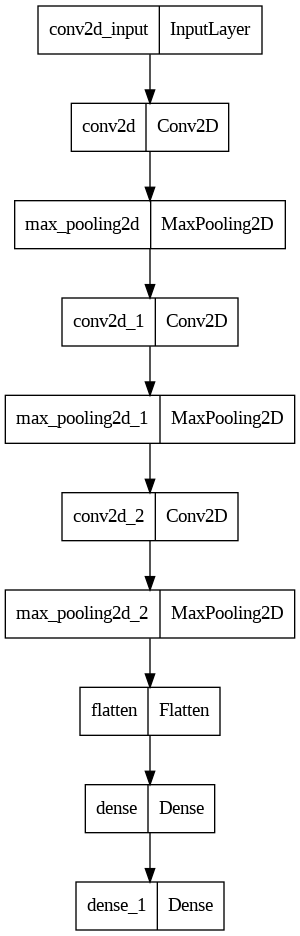

In [24]:
model.summary()
plot_model(model, path + 'net.binary.png')

In [25]:
net_LCT = ImaNet(name='[C32+P]x2+[C64+P]+D128')

train batches from 1-9

1
29/29 [==============================] - 82s 3s/step - loss: 5.2474 - accuracy: 0.6122 - val_loss: 3.7446 - val_accuracy: 0.5850
2
29/29 [==============================] - 80s 3s/step - loss: 2.6515 - accuracy: 0.7394 - val_loss: 1.6894 - val_accuracy: 0.8800
3
29/29 [==============================] - 81s 3s/step - loss: 1.1660 - accuracy: 0.9206 - val_loss: 0.7235 - val_accuracy: 0.9750
4
29/29 [==============================] - 79s 3s/step - loss: 0.6516 - accuracy: 0.9572 - val_loss: 0.5030 - val_accuracy: 0.9950
5
29/29 [==============================] - 78s 3s/step - loss: 0.4867 - accuracy: 0.9667 - val_loss: 0.4053 - val_accuracy: 0.9900
6
29/29 [==============================] - 79s 3s/step - loss: 0.4106 - accuracy: 0.9694 - val_loss: 0.3563 - val_accuracy: 0.9950
7
29/29 [==============================] - 83s 3s/step - loss: 0.3479 - accuracy: 0.9817 - val_loss: 0.2944 - val_accuracy: 0.9950
8
29/29 [==============================] - 78s 3s/step - loss: 0.3161 - accuracy: 0

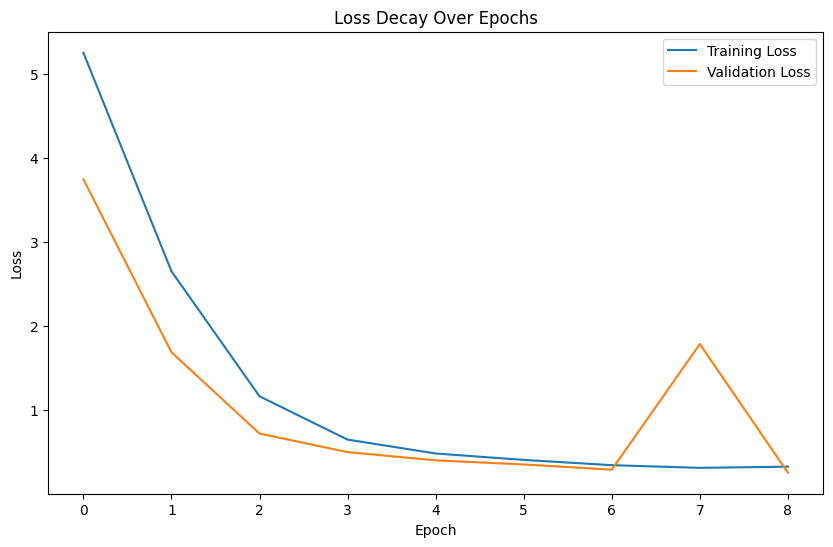

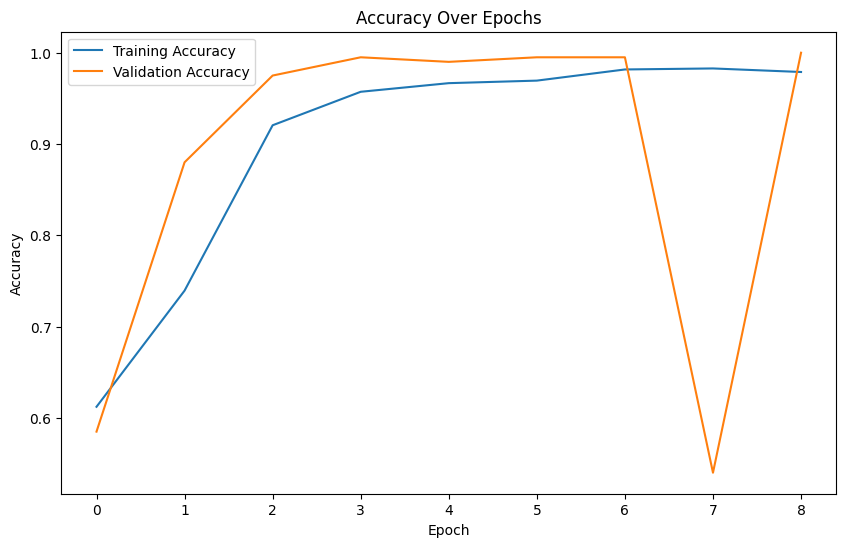

In [26]:
import csv


total_epochs = 0
losses = []
val_losses = []
accuracies = []
val_accuracies = []

i = 1
while i < 10:
    print(i)

    file_sim = ImaFile(simulations_folder=path_sim + 'ES/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)

    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

    # Append the loss, validation loss, accuracy, and validation accuracy values for each epoch
    losses.extend(score.history['loss'])
    val_losses.extend(score.history['val_loss'])
    accuracies.extend(score.history['accuracy'])
    val_accuracies.extend(score.history['val_accuracy'])

    # Update the total number of epochs trained
    total_epochs += len(score.history['loss'])

    net_LCT.update_scores(score)

    i += 1

# Print the total number of epochs
print(f'Total epochs trained: {total_epochs}')

# Save the loss, validation loss, accuracy, and validation accuracy to a CSV file
with open('training_metrics.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    for epoch in range(total_epochs):
        training_loss = losses[epoch] if epoch < len(losses) else ''
        validation_loss = val_losses[epoch] if epoch < len(val_losses) else ''
        training_accuracy = accuracies[epoch] if epoch < len(accuracies) else ''
        validation_accuracy = val_accuracies[epoch] if epoch < len(val_accuracies) else ''
        csvwriter.writerow([epoch + 1, training_loss, validation_loss, training_accuracy, validation_accuracy])

# Plot the loss and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), losses, label='Training Loss')
plt.plot(range(total_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Decay Over Epochs')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), accuracies, label='Training Accuracy')
plt.plot(range(total_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

We can plot loss and validation accuracy during the training to check, for instance, for overfitting.

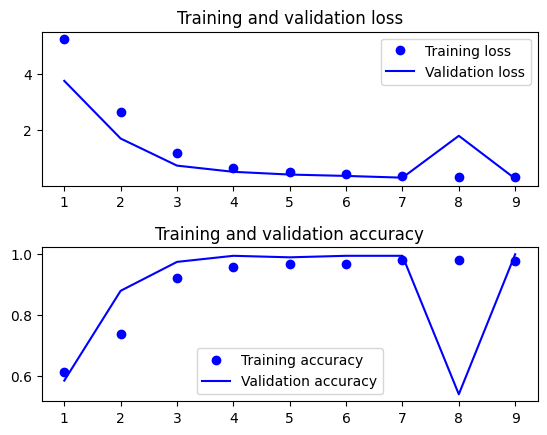

0

In [27]:
net_LCT.plot_train()

We save (and/or load) the final trained model.

In [28]:
model.save(path + 'model.EW.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
model = load_model(path + 'model.EW.h5')

You can also save the network itself (and load it).

In [30]:
net_LCT.save(path + 'net_LCT.ES');

In [31]:
net_LCT = load_imanet(path + 'net_LCT.ES')

Finally, we evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [32]:
i = 10
file_sim = ImaFile(simulations_folder=path_sim + 'ES/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((198, 192))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test)
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets);

Let's report loss and accuracy on the testing set.

In [33]:

net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test)  # it will report [loss, accuracy]



[0.2702796161174774, 0.9925000071525574]


63/63 [==============================] - 24s 377ms/step


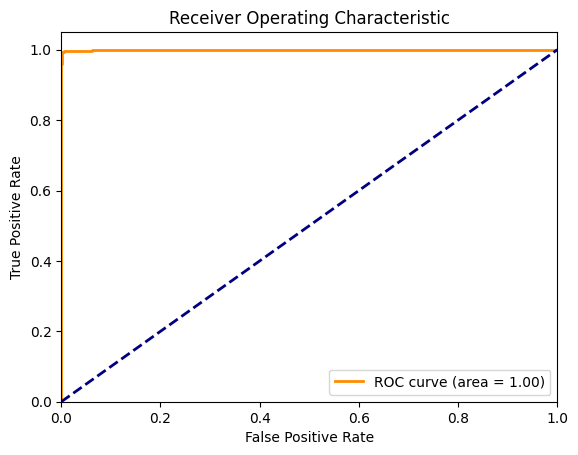

Sensitivity (Recall): 0.99
Specificity: 1.00
Precision: 1.00
F1 Score: 0.99


In [34]:
# Add the following code for ROC and AUC calculation and plotting
y_pred_prob = model.predict(gene_sim_test.data)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(gene_sim_test.targets, y_pred).ravel()

# Calculate sensitivity (recall)
sensitivity = recall_score(gene_sim_test.targets, y_pred)

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(gene_sim_test.targets, y_pred)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, y_pred)

# Print metrics
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

For a binary (or multiclass) classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

63/63 [==============================] - 23s 372ms/step


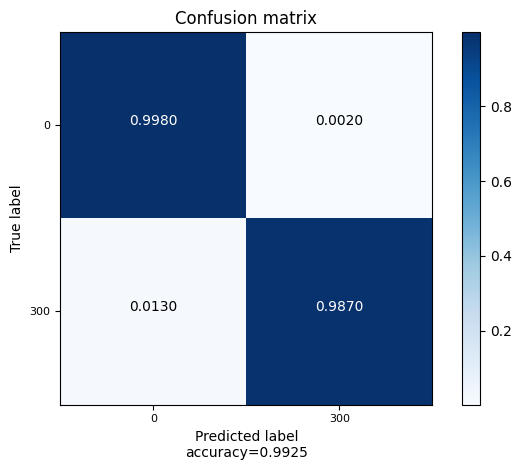

0

In [35]:
net_LCT.predict(gene_sim_test, model)
net_LCT.plot_cm(gene_sim_test.classes, text=True)

 Deploy trained network on real genomic region
now the network is trained we can see how it fairs against real genomic data

In [36]:
print(model.predict(gene_LCT.data, batch_size=None)[0][0])

1/1 [==============================] - 0s 36ms/step
0.99463505
